
<center>
<img src="https://i.postimg.cc/26RtyM0s/3221asdf.jpg" width=1100>
</center>



# <div  style="color:white; border:lightgreen solid;  font-weight:bold; font-size:120%; text-align:center;padding:12.0px; background:black">1. OVERVIEW</div>

# Goal
The objective of this competition is to create an algorithm that is capable of solving abstract reasoning tasks. Critically, these are novel tasks: tasks that the algorithm has never seen before. Hence, **simply memorizing** a set of reasoning templates will **not suffice**.

The goal is to construct the output grid(s) corresponding to the test input grid(s), using 2 trials for each test input.

# Data overview

 

"Constructing the output grid" involves picking the height and width of the output grid, then filling each cell in the grid with a symbol (integer between 0 and 9, which are visualized as **colors**). **Only exact solutions** (all cells match the expected answer) can be said to be correct.

# <div  style="color:white; border:lightgreen solid;  font-weight:bold; font-size:120%; text-align:center;padding:12.0px; background:black">2. DATA LOADING AND PREPARATION</div>

## Import libraries and define parameters

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from   matplotlib import colors
import seaborn as sns

import json
import os
from pathlib import Path

from subprocess import Popen, PIPE, STDOUT
from glob import glob

In [2]:
base_path='/kaggle/input/arc-prize-2024/'
# Loading JSON data
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

In [3]:
# Reading files
training_challenges =  load_json(base_path +'arc-agi_training_challenges.json')
training_solutions =   load_json(base_path +'arc-agi_training_solutions.json')
evaluation_challenges =load_json(base_path +'arc-agi_evaluation_challenges.json')
evaluation_solutions = load_json(base_path +'arc-agi_evaluation_solutions.json')


# <div  style="color:white; border:lightgreen solid;  font-weight:bold; font-size:120%; text-align:center;padding:12.0px; background:black">3. DATA EXPLORATION</div>

All datasets have 400 JSON tasks:

In [4]:
print(f'Number of training challenges = {len(training_challenges)}')

Number of training challenges = 400


In [5]:
print(f'Number of training solutions = {len(training_solutions)}')

Number of training solutions = 400


In [6]:
print(f'Number of evaluation challenges = {len(evaluation_challenges)}')

Number of evaluation challenges = 400


In [7]:
print(f'Number of evaluation solutions = {len(evaluation_solutions)}')

Number of evaluation solutions = 400


The names of the first fife ""training challenges" are shown below:

In [8]:
for i in range(5):
    t=list(training_challenges)[i]
    task=training_challenges[t]
    print(f'Set #{i}, {t}')

Set #0, 007bbfb7
Set #1, 00d62c1b
Set #2, 017c7c7b
Set #3, 025d127b
Set #4, 045e512c


In each task, there are **two** dictionary keys, **train** and **test**. We learn the pattern from the train input-output pairs, and then apply the pattern to the test input, to predict an output.

In [9]:
task = training_challenges['007bbfb7']
print(task.keys())

dict_keys(['test', 'train'])


Tasks have multiple train input-output pairs. Most tasks have a single test input-output pair, although some have more than one.

In [10]:
n_train_pairs = len(task['train'])
n_test_pairs = len(task['test'])

print(f'task contains {n_train_pairs} training pairs')
print(f'task contains {n_test_pairs} test pairs')

task contains 5 training pairs
task contains 1 test pairs


Dive into the first train input-output pair, we can see the grids are expressed as 2d lists with integers 0-9:

In [11]:
display(task['train'][0]['input'])
display(task['train'][0]['output'])

[[0, 7, 7], [7, 7, 7], [0, 7, 7]]

[[0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 7, 7, 7, 7, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 7, 7, 0, 7, 7, 0, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7],
 [0, 7, 7, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 7, 7, 7, 7, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7]]

### Function to plot input/output pairs of a task

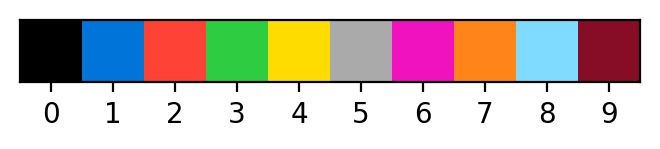

In [12]:
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown

_cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

plt.figure(figsize=(4, 1), dpi=200)
plt.imshow([list(range(10))], cmap=_cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

In [13]:
def plot_one(ax, i,train_or_test,input_or_output):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)

    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+input_or_output)
    

def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(axs[0,i],i,'train','input')
        plot_one(axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
#     num_test = len(task['test'])
#     fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
#     if num_test==1: 
#         plot_one(axs[0],0,'test','input')
#         plot_one(axs[1],0,'test','output')     
#     else:
#         for i in range(num_test):      
#             plot_one(axs[0,i],i,'test','input')
#             plot_one(axs[1,i],i,'test','output')  
#     plt.tight_layout()
#     plt.show()

# Visualization Training set

Set #0, 007bbfb7


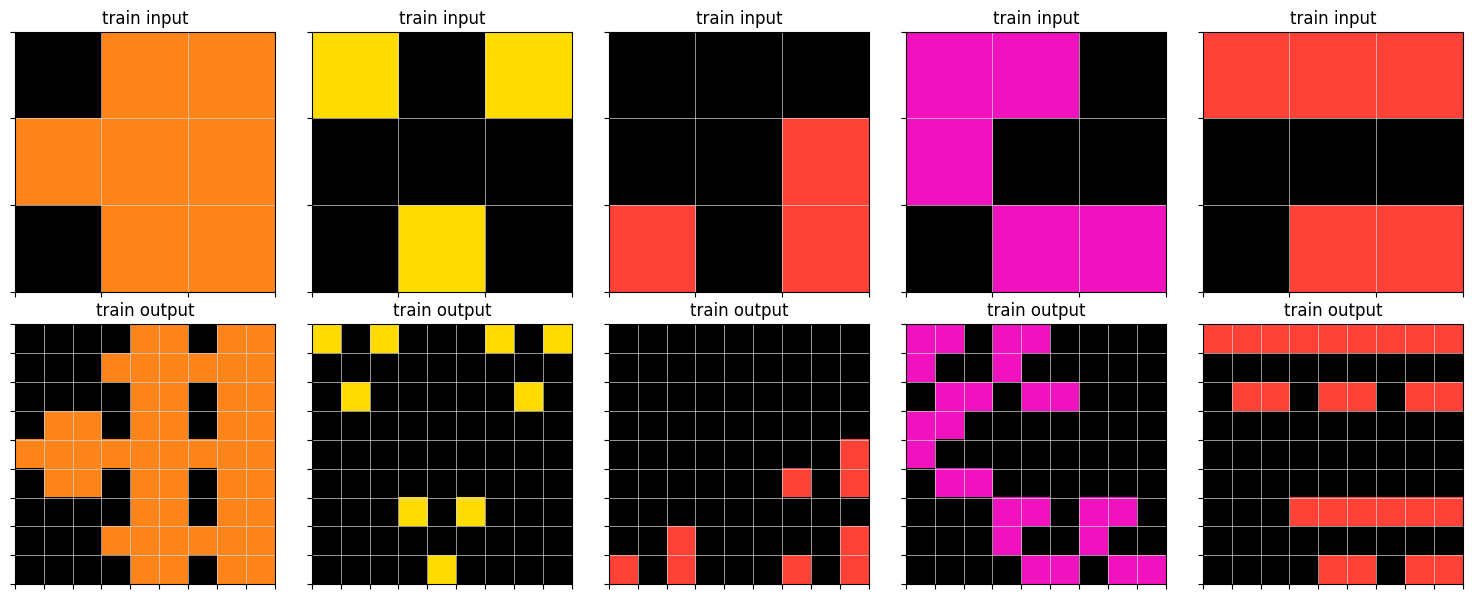

Set #1, 00d62c1b


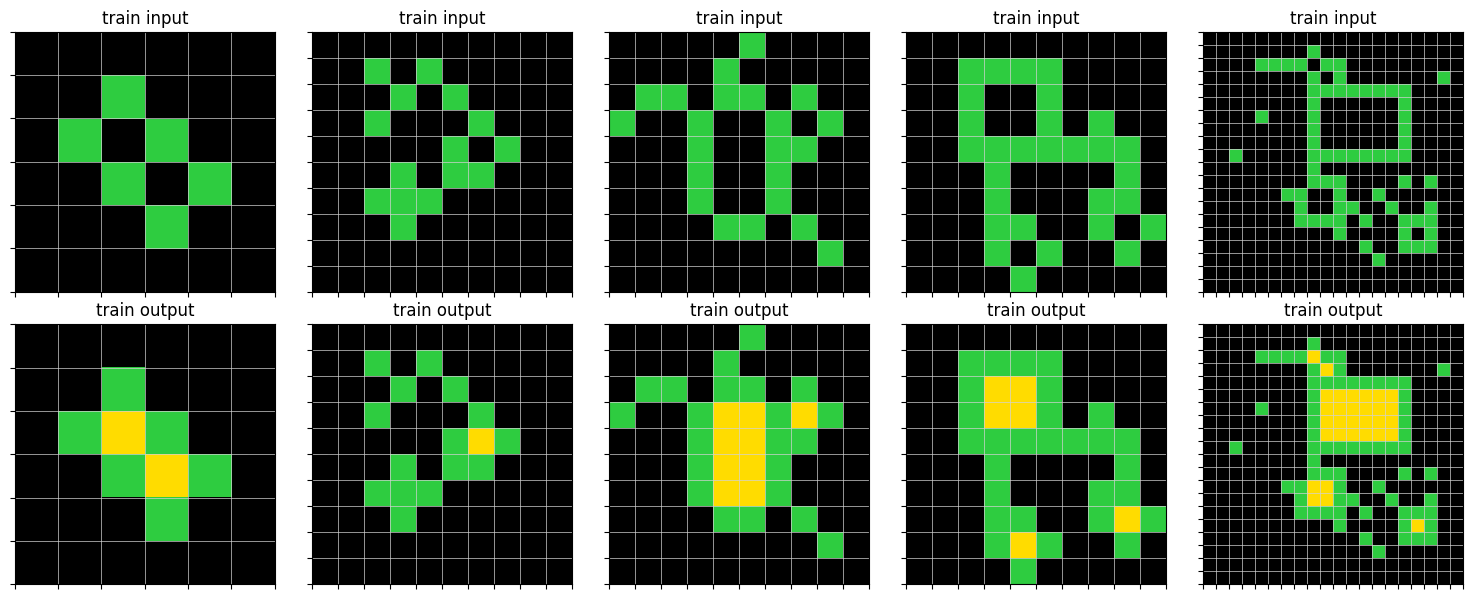

Set #2, 017c7c7b


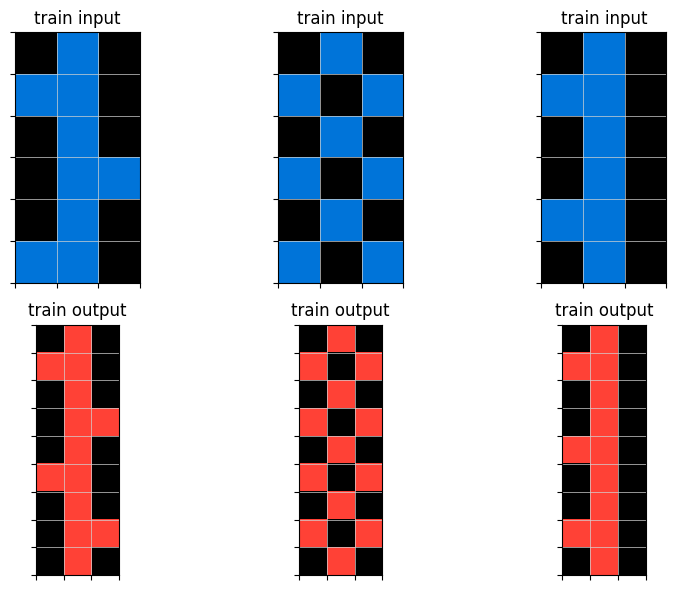

Set #3, 025d127b


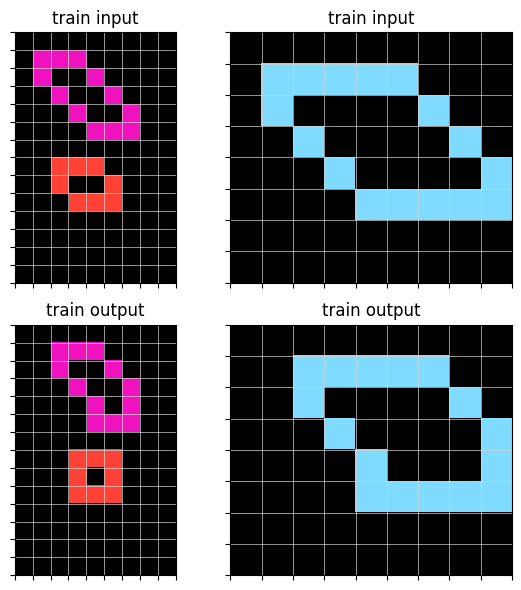

Set #4, 045e512c


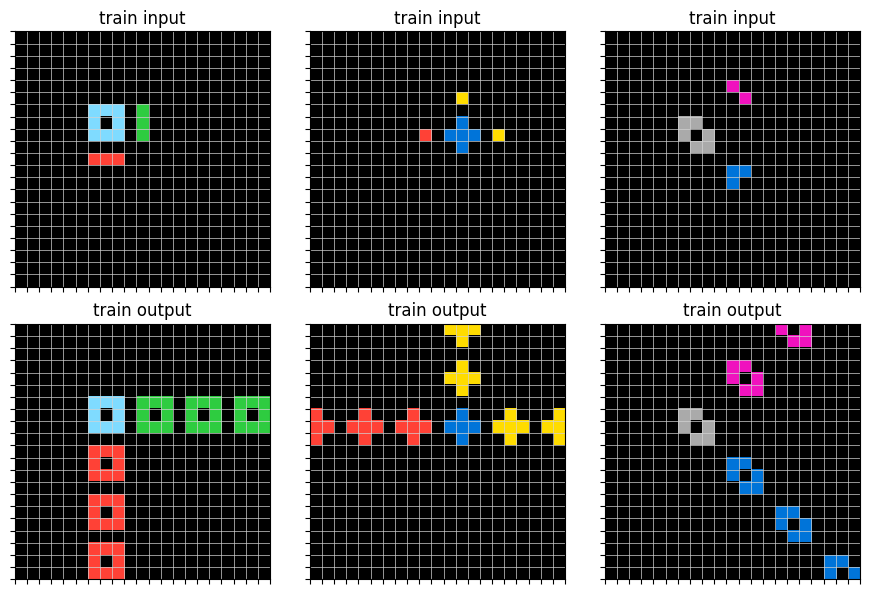

In [14]:
for i in range(5):
    t=list(training_challenges)[i]
    task=training_challenges[t]
    print(f'Set #{i}, {t}')
    plot_task(task)

# Visualization Evaluating set

Set #0, 00576224


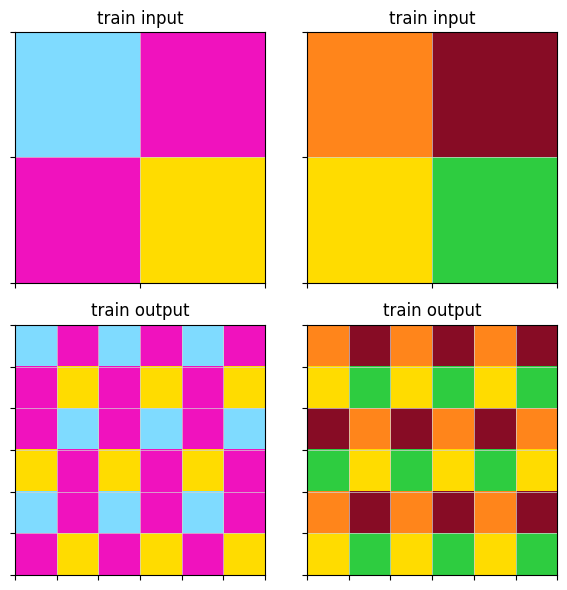

Set #1, 009d5c81


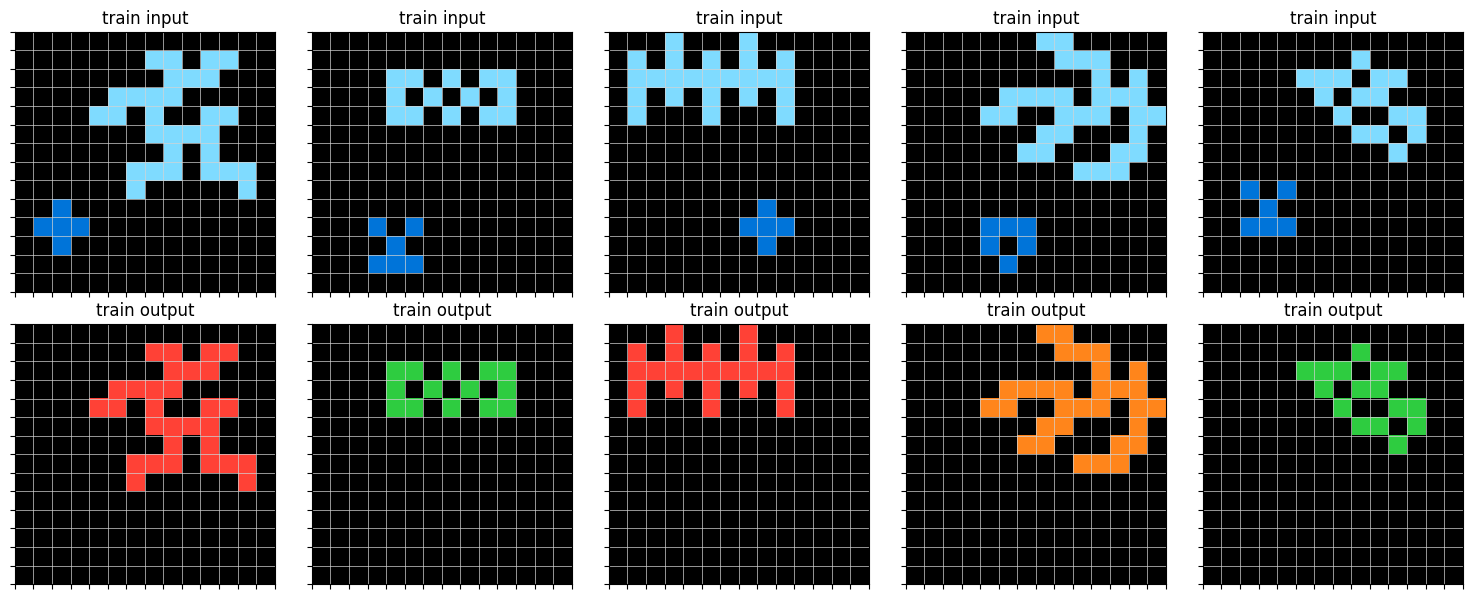

Set #2, 00dbd492


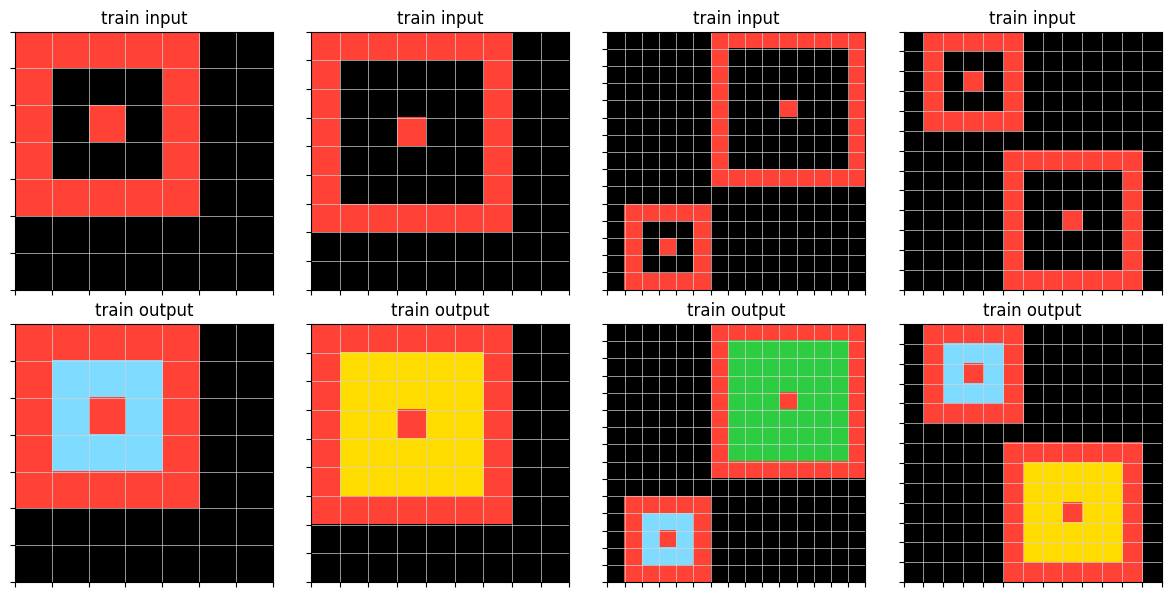

Set #3, 03560426


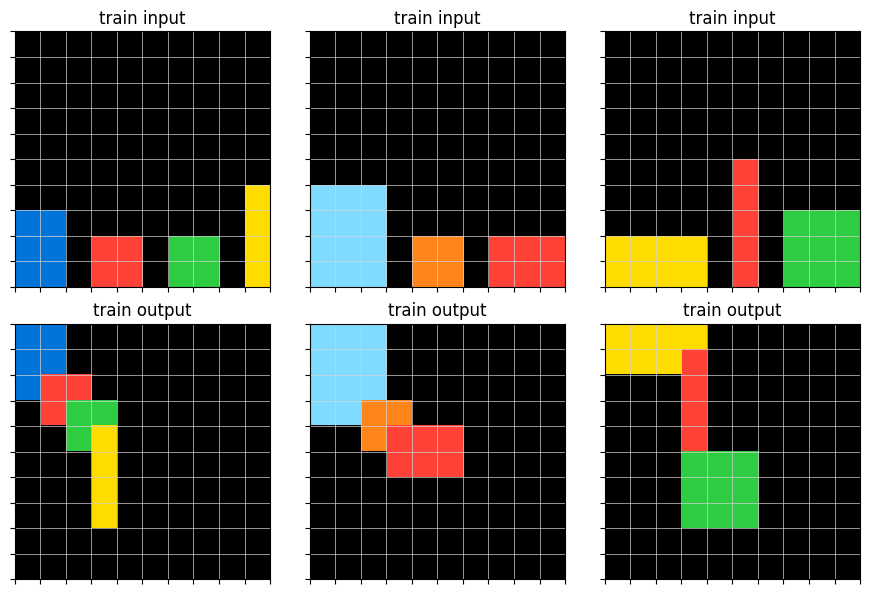

Set #4, 05a7bcf2


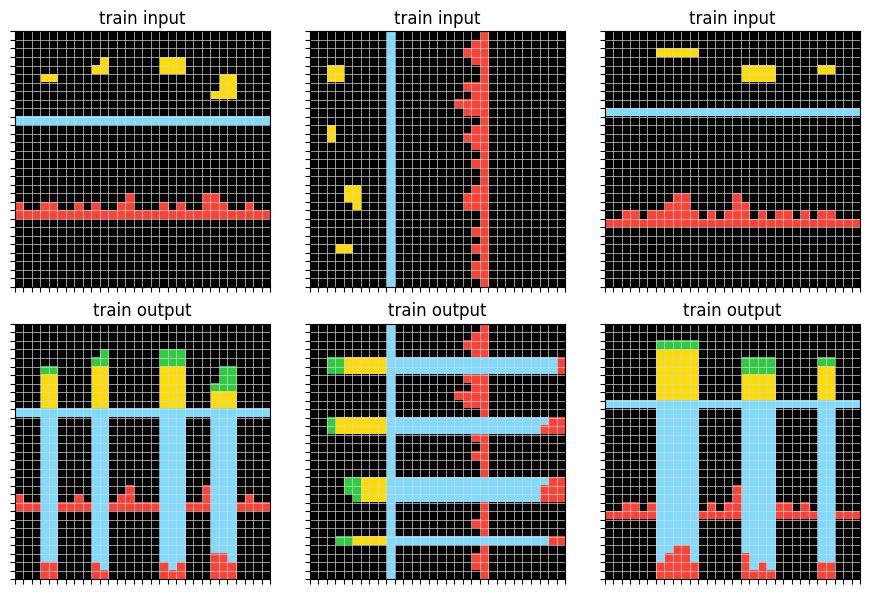

In [15]:
for i in range(5):
    t=list(evaluation_challenges)[i]
    task=evaluation_challenges[t]
    print(f'Set #{i}, {t}')
    plot_task(task)


# <div  style="color:white; border:lightgreen solid;  font-weight:bold; font-size:120%; text-align:center;padding:12.0px; background:black">4. MODELLING</div>

Set #0, 007bbfb7


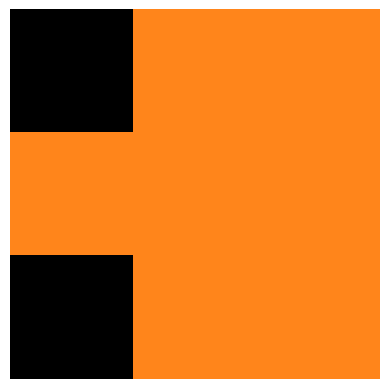

In [16]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from typing import Literal

def create_rgb_array(input_output_matrix):
#     print("Matrix:")
#     print(input_output_matrix)
    
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)

    normed_matrix = norm(input_output_matrix)
    rgb_array = cmap(normed_matrix)
    rgb_array = rgb_array[..., :3]
    
#     print("RGB Array (Normalized):")
#     print(rgb_array)
    
    return rgb_array

def get_rgb_task(task, kind:Literal['train', 'test']='train'):
    num_train = len(task[kind])
    train_input_rgb = []
    train_output_rgb = []
    
    for i in range(num_train):
        input_matrix = task[kind][i]['input']
        output_matrix = task[kind][i]['output']
        
        train_input_rgb.append(create_rgb_array(input_matrix))
        train_output_rgb.append(create_rgb_array(output_matrix))
        
    return train_input_rgb, train_output_rgb

def display_with_matplotlib(rgb_array):
    plt.imshow(rgb_array)
    plt.axis('off')
    plt.show()

t = list(training_challenges)[0]
task = training_challenges[t]
print(f'Set #{0}, {t}')
# plot_task(task)
train_input_rgb, train_output_rgb = get_rgb_task(task, 'train')
display_with_matplotlib(train_input_rgb[0])


In [17]:
import numpy as np
import torch
import torch.nn as nn
import bisect
from typing import List, Tuple, Literal
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
import matplotlib.colors as colors
import pickle


In [18]:
import json
import pickle
import numpy as np
import matplotlib.colors as colors
from typing import Literal

# Constants for maximum grid dimensions
MAX_ROWS, MAX_COLS = 30, 30

# Pad the array to the given dimensions
def pad_array(array, max_rows=MAX_ROWS, max_cols=MAX_COLS, padding_value=-1.0):
    padded_array = np.full((max_rows, max_cols), padding_value)
    rows, cols = len(array), len(array[0])
    start_row = (max_rows - rows) // 2
    start_col = (max_cols - cols) // 2
    padded_array[start_row:start_row+rows, start_col:start_col+cols] = array
    return padded_array

# Convert the padded array to RGB
def create_rgb_array(input_matrix):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    normed_matrix = norm(input_matrix)
    rgb_array = cmap(normed_matrix)
    rgb_array = rgb_array[..., :3]
    return rgb_array

# Get padded RGB arrays for the task
def get_padded_rgb_task(task, kind: Literal['train', 'test'] = 'train'):
    input_rgb, output_rgb = [], []
    for pair in task[kind]:
        input_matrix = pad_array(pair['input'])
        input_rgb.append(create_rgb_array(input_matrix))
        if 'output' in pair:
            output_matrix = pad_array(pair['output'])
            output_rgb.append(create_rgb_array(output_matrix))
        else:
            output_rgb.append(None)
    return input_rgb, output_rgb




In [19]:
# Process and save the dataset with size information
def save_dataset_with_sizes(training_challenges, filename):
    dataset = {
        'train_input_rgb': [],
        'train_output_rgb': [],
        'test_input_rgb': [],
        'train_input_sizes': [],
        'train_output_sizes': [],
        'test_input_sizes': [],
        'labels': []
    }

    for i in range(len(training_challenges)):
        t = list(training_challenges)[i]
        task = training_challenges[t]
        print(f'Processing Set #{i}, {t}', end='\r')
        
        # Process training pairs
        train_input_rgb, train_output_rgb = get_padded_rgb_task(task, 'train')
        for j in range(len(task['train'])):
            input_matrix = task['train'][j]['input']
            output_matrix = task['train'][j]['output']
            dataset['train_input_rgb'].append(train_input_rgb[j])
            dataset['train_output_rgb'].append(train_output_rgb[j])
            dataset['train_input_sizes'].append((len(input_matrix), len(input_matrix[0])))
            dataset['train_output_sizes'].append((len(output_matrix), len(output_matrix[0])))
            dataset['labels'].append(t)
        
        # Process test pairs (only inputs)
        test_input_rgb, _ = get_padded_rgb_task(task, 'test')
        for k in range(len(task['test'])):
            input_matrix = task['test'][k]['input']
            dataset['test_input_rgb'].append(test_input_rgb[k])
            dataset['test_input_sizes'].append((len(input_matrix), len(input_matrix[0])))

    # Debug: Verify dataset content
    print(f"\nTotal valid train samples: {len(dataset['train_input_rgb'])}")
    print(f"Total valid test samples: {len(dataset['test_input_rgb'])}")

    # Save the dataset to a file using pickle
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)

    print(f'\nDataset saved to {filename}')

# Example usage
save_dataset_with_sizes(training_challenges, 'processed_dataset_with_sizes.pkl')



Processing Set #399, ff805c23
Total valid train samples: 1301
Total valid test samples: 416

Dataset saved to processed_dataset_with_sizes.pkl


In [20]:
import torch
import numpy as np
import pickle

# Function to flatten RGB arrays with size information
def flatten_rgb_arrays_with_sizes(rgb_arrays, sizes):
    flattened_arrays = []
    for rgb_array, size in zip(rgb_arrays, sizes):
        flattened_array = rgb_array.flatten()
        flattened_arrays.append(np.concatenate((flattened_array, np.array(size))))
    return np.array(flattened_arrays)

# Function to reshape predictions back to 2D
def reshape_predictions(predictions, sizes):
    reshaped_predictions = []
    num_features = predictions.shape[1] - 2  # excluding size information
    for i, size in enumerate(sizes):
        height, width = size
        reshaped_prediction = predictions[i][:num_features].reshape(height, width, 3)
        reshaped_predictions.append(reshaped_prediction)
    return reshaped_predictions

# Function to calculate accuracy
def calculate_accuracy(predictions, ground_truth):
    correct = 0
    for pred, gt in zip(predictions, ground_truth):
        if np.array_equal(pred, gt):
            correct += 1
    accuracy = correct / len(ground_truth)
    return accuracy

# Load the dataset with size information
def load_dataset_with_sizes(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

# Example usage
dataset = load_dataset_with_sizes('processed_dataset_with_sizes.pkl')
train_input_rgb = dataset['train_input_rgb']
train_output_rgb = dataset['train_output_rgb']
test_input_rgb = dataset['test_input_rgb']
train_input_sizes = dataset['train_input_sizes']
train_output_sizes = dataset['train_output_sizes']
test_input_sizes = dataset['test_input_sizes']
labels = dataset['labels']

# # Flatten the train data for validation
# train_input_rgb_flat = flatten_rgb_arrays_with_sizes(train_input_rgb, train_input_sizes)
# train_output_rgb_flat = flatten_rgb_arrays_with_sizes(train_output_rgb, train_output_sizes)

# X_train = torch.FloatTensor(train_input_rgb_flat)
# y_train = torch.FloatTensor(train_output_rgb_flat)

# # Debug: Print shapes
# print(f"X_train shape: {X_train.shape}")
# print(f"y_train shape: {y_train.shape}")

# # Make predictions with the trained model for validation
# with torch.no_grad():
#     outputs = trained_model(X_train)

# # Debug: Print shapes after prediction
# print(f"Outputs shape after prediction: {outputs.shape}")

# # Reshape the predictions
# reshaped_predictions = reshape_predictions(outputs.numpy(), train_output_sizes)
# reshaped_ground_truth = reshape_predictions(y_train.numpy(), train_output_sizes)

# # Debug: Print lengths after reshaping
# print(f"Reshaped predictions length: {len(reshaped_predictions)}")
# print(f"Reshaped ground truth length: {len(reshaped_ground_truth)}")

# # Calculate accuracy
# accuracy = calculate_accuracy(reshaped_predictions, reshaped_ground_truth)
# print(f'Accuracy: {accuracy:.4f}')


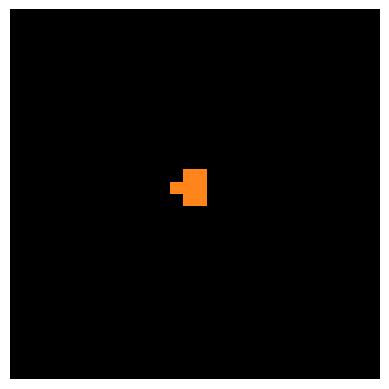

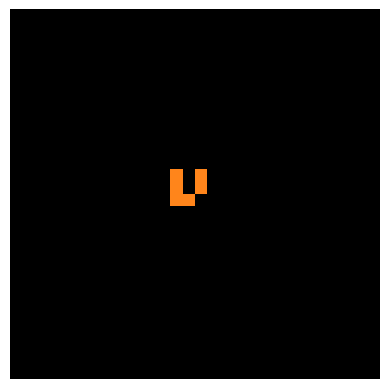

In [21]:
# import pickle

# # Load the dataset with size information
# def load_dataset_with_sizes(filename):
#     with open(filename, 'rb') as f:
#         dataset = pickle.load(f)
#     return dataset

# # Example usage
# dataset = load_dataset_with_sizes('processed_dataset_with_sizes.pkl')
# train_input_rgb = dataset['train_input_rgb']
# train_output_rgb = dataset['train_output_rgb']
# test_input_rgb = dataset['test_input_rgb']
# train_input_sizes = dataset['train_input_sizes']
# train_output_sizes = dataset['train_output_sizes']
# test_input_sizes = dataset['test_input_sizes']
# labels = dataset['labels']

# Display the first example of train set
display_with_matplotlib(train_input_rgb[0])

# If you want to display the first example of the test set (if it exists)
if test_input_rgb and test_input_rgb[0] is not None:
    display_with_matplotlib(test_input_rgb[0])


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import os

class SplineActivation(nn.Module):
    def __init__(self, num_knots=10, degree=3):
        super(SplineActivation, self).__init__()
        self.num_knots = num_knots
        self.degree = degree
        self.x = nn.Parameter(torch.linspace(-1.0, 1.0, num_knots), requires_grad=False)

        # Allow y to be updated during training
        self.y = nn.Parameter(torch.sin(self.x * 3.14159) + 0.1 * torch.randn(self.num_knots), requires_grad=True)

        # Initial computation of coefficients, just for initial debugging
        _, self.coefficients = self.compute_spline(self.x, self.y)

        self.w = nn.Parameter(torch.tensor(1.0))  # Initialize weight
        self.basis_function = nn.SiLU()  # Using SiLU (Swish) as basis function

    def compute_spline(self, x, y):
        if x.size(0) < 3:
            raise ValueError('Too short an array')
        if x.size(0) != y.size(0):
            raise ValueError('Array lengths are different')

        h = x[1:] - x[:-1]
        if torch.any(h <= 0):
            raise ValueError('X must be strictly increasing')

        n = x.size(0)
        A, B, C = self.create_tridiagonal_matrix(n, h)
        D = self.create_target(n, h, y)
        M = self.solve_tridiagonal_system(A, B, C, D)

        coefficients = torch.stack([
            (M[1:] - M[:-1]) * h**2 / 6,
            M[:-1] * h**2 / 2,
            (y[1:] - y[:-1] - (M[1:] + 2 * M[:-1]) * h**2 / 6),
            y[:-1]
        ], dim=1)

        return self.spline_function(x, coefficients), coefficients

    def create_tridiagonal_matrix(self, n, h):
        A = torch.cat((h[:-1] / (h[:-1] + h[1:]), torch.tensor([0.0], device=h.device)))
        B = torch.full((n,), 2.0, device=h.device)
        C = torch.cat((torch.tensor([0.0], device=h.device), h[1:] / (h[:-1] + h[1:])))
        return A, B, C

    def create_target(self, n, h, y):
        diff_quotients = 6 * ((y[2:] - y[1:-1]) / h[1:] - (y[1:-1] - y[:-2]) / h[:-1]) / (h[:-1] + h[1:])
        return torch.cat((torch.tensor([0.0], device=h.device), diff_quotients, torch.tensor([0.0], device=h.device)))

    def solve_tridiagonal_system(self, A, B, C, D):
        n = B.size(0)
        c_p = torch.zeros(n, device=B.device)
        d_p = torch.zeros(n, device=B.device)
        X = torch.zeros(n, device=B.device)

        c_p[0] = C[0] / B[0]
        d_p[0] = D[0] / B[0]
        for i in range(1, n-1):
            denom = B[i] - A[i-1] * c_p[i-1]
            c_p[i] = C[i] / denom
            d_p[i] = (D[i] - A[i-1] * d_p[i-1]) / denom

        X[-1] = d_p[-1]
        for i in range(n-2, -1, -1):
            X[i] = d_p[i] - c_p[i] * X[i+1]

        return X

    def spline_function(self, x, coefficients):
        def spline(val):
            idx = min(bisect.bisect(x.cpu().numpy(), val) - 1, x.size(0) - 2)
            z = (val - x[idx].item()) / (x[idx+1].item() - x[idx].item())
            C = coefficients[idx]
            return (((C[0] * z + C[1]) * z + C[2]) * z + C[3]).item()
        return spline

    def forward(self, x):
        x_clipped = torch.clamp(x, -1, 1)

        _, coefficients = self.compute_spline(self.x, self.y)

        indices = torch.searchsorted(self.x, x_clipped.detach(), right=True) - 1
        indices = torch.clamp(indices, 0, self.num_knots - 2)
        idx_x = self.x[indices]
        idx_x1 = self.x[indices + 1]
        h = idx_x1 - idx_x
        z = (x_clipped - idx_x) / h
        C = coefficients[indices]

        z = z.unsqueeze(-1)
        C = C.unsqueeze(2)
        y_clipped = (((C[..., 0] * z + C[..., 1]) * z + C[..., 2]) * z + C[..., 3])

        return self.w * (self.basis_function(x) + y_clipped.squeeze(-1))

class KAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_type='spline', num_knots=10):
        super(KAN, self).__init__()
        self.phi1 = nn.Linear(input_dim, hidden_dim)
        self.psi1 = nn.Linear(input_dim, hidden_dim)
        self.phi2 = nn.Linear(hidden_dim, hidden_dim)
        self.psi2 = nn.Linear(hidden_dim, hidden_dim)
        self.phi3 = nn.Linear(hidden_dim, output_dim)
        self.psi3 = nn.Linear(hidden_dim, output_dim)
        self._he_init()

        if kernel_type == 'spline':
            self.spline1 = SplineActivation(num_knots)
            self.spline2 = SplineActivation(num_knots)
            self.spline3 = SplineActivation(num_knots)
            self.spline4 = SplineActivation(num_knots)
            self.spline5 = SplineActivation(num_knots)
            self.spline6 = SplineActivation(num_knots)

    # He initialization function
    def _he_init(self):
        for layer in [self.phi1, self.psi1, self.phi2, self.psi2, self.phi3, self.psi3]:
#         for layer in [self.phi1, self.phi2, self.phi3]:
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        def apply_activation(act, x):
            return act(x)

        x1 = apply_activation(self.spline1, self.phi1(x))
        x2 = apply_activation(self.spline2, self.psi1(x))
        sum_x = x1 + x2
        x3 = apply_activation(self.spline3, self.phi2(sum_x))
        x4 = apply_activation(self.spline4, self.psi2(sum_x))
        sum_x2 = x3 + x4
        x5 = apply_activation(self.spline5, self.phi3(sum_x2))
        x6 = apply_activation(self.spline6, self.psi3(sum_x2))
        output = x5 + x6
#         return torch.tanh(output)
        return output
    
def train_model(model, X_train, y_train, epochs=200, learning_rate=0.01, save_step=10, save_path="model_checkpoints", device='cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ExponentialLR(optimizer, gamma=0.975)

    loss_list = []

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        if (epoch + 1) % save_step == 0:
            scheduler.step()

            torch.save(model.state_dict(), os.path.join(save_path, f"model_epoch_{epoch + 1}.pth"))
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Model saved.")

    print(f"Training complete! Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return model, loss_list    

In [50]:

# Set global seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Usage for GPU/CPU

# Choose the device based on availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Flatten the train data
train_input_rgb_flat = flatten_rgb_arrays_with_sizes(train_input_rgb, train_input_sizes)
train_output_rgb_flat = flatten_rgb_arrays_with_sizes(train_output_rgb, train_output_sizes)

X_train = torch.FloatTensor(train_input_rgb_flat)
y_train = torch.FloatTensor(train_output_rgb_flat)

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
hidden_dim = (input_dim + output_dim)//60

num_knots = 30
epochs = 2000
learning_rate = 0.01
save_step = 10
save_path = f"k{num_knots}_id{input_dim}_hd{hidden_dim}_od{output_dim}_model_checkpoints"
print(f'Saving model to {save_path}')

kan_model = KAN(input_dim, hidden_dim, output_dim, kernel_type='spline', num_knots=num_knots)
trained_model, loss_list = train_model(kan_model, X_train, y_train, epochs=epochs, learning_rate=learning_rate, save_step=save_step, save_path=save_path, device=device)


Saving model to k30_id2702_hd90_od2702_model_checkpoints
Epoch [10/2000], Loss: 0.2804, Model saved.
Epoch [20/2000], Loss: 0.0564, Model saved.
Epoch [30/2000], Loss: 0.0488, Model saved.
Epoch [40/2000], Loss: 0.0432, Model saved.
Epoch [50/2000], Loss: 0.0388, Model saved.
Epoch [60/2000], Loss: 0.0369, Model saved.
Epoch [70/2000], Loss: 0.0357, Model saved.
Epoch [80/2000], Loss: 0.0345, Model saved.
Epoch [90/2000], Loss: 0.0337, Model saved.
Epoch [100/2000], Loss: 0.0329, Model saved.
Epoch [110/2000], Loss: 0.0322, Model saved.
Epoch [120/2000], Loss: 0.0315, Model saved.
Epoch [130/2000], Loss: 0.0310, Model saved.
Epoch [140/2000], Loss: 0.0304, Model saved.
Epoch [150/2000], Loss: 0.0299, Model saved.
Epoch [160/2000], Loss: 0.0295, Model saved.
Epoch [170/2000], Loss: 0.0291, Model saved.
Epoch [180/2000], Loss: 0.0287, Model saved.
Epoch [190/2000], Loss: 0.0284, Model saved.
Epoch [200/2000], Loss: 0.0281, Model saved.
Epoch [210/2000], Loss: 0.0278, Model saved.
Epoch [

In [ ]:
import torch
import numpy as np

# Function to reshape predictions back to 2D
def reshape_predictions(predictions, sizes):
    reshaped_predictions = []
    num_features = predictions.shape[1] - 2  # excluding size information
    for i, size in enumerate(sizes):
        height, width = size
        reshaped_prediction = predictions[i][:num_features].reshape(height, width, 3)
        reshaped_predictions.append(reshaped_prediction)
    return reshaped_predictions

# Function to calculate accuracy
def calculate_accuracy(predictions, ground_truth):
    correct = 0
    for pred, gt in zip(predictions, ground_truth):
        if np.array_equal(pred, gt):
            correct += 1
    accuracy = correct / len(ground_truth)
    return accuracy

# Function to load and evaluate the model
def evaluate_model(model, X_test, y_test, test_output_sizes, device='cpu'):
    model.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        outputs = model(X_test)
    
    reshaped_predictions = reshape_predictions(outputs.cpu().numpy(), test_output_sizes)
    reshaped_ground_truth = reshape_predictions(y_test.cpu().numpy(), test_output_sizes)

    accuracy = calculate_accuracy(reshaped_predictions, reshaped_ground_truth)
    print(f'Accuracy: {accuracy:.4f}')
    return accuracy

test_input_rgb = dataset['train_input_rgb']
test_output_rgb = dataset['train_output_rgb']
test_input_sizes = dataset['train_input_sizes']
test_output_sizes = dataset['train_output_sizes']

test_input_rgb_flat = flatten_rgb_arrays_with_sizes(test_input_rgb, test_input_sizes)
test_output_rgb_flat = flatten_rgb_arrays_with_sizes(test_output_rgb, test_output_sizes)

X_test = torch.FloatTensor(test_input_rgb_flat)
y_test = torch.FloatTensor(test_output_rgb_flat)

# Load the trained model
trained_model = KAN(input_dim, hidden_dim, output_dim, kernel_type='spline', num_knots=num_knots)
trained_model.load_state_dict(torch.load('model_checkpoints/model_epoch_2000.pth'))

# Evaluate the model
evaluate_model(trained_model, X_test, y_test, test_output_sizes, device=device)


In [ ]:
# Example usage for TPU
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp

def _mp_fn(rank, flags):
    device = xm.xla_device()
    # Flatten the train data
    train_input_rgb_flat = flatten_rgb_arrays_with_sizes(train_input_rgb, train_input_sizes)
    train_output_rgb_flat = flatten_rgb_arrays_with_sizes(train_output_rgb, train_output_sizes)

    X_train = torch.FloatTensor(train_input_rgb_flat)
    y_train = torch.FloatTensor(train_output_rgb_flat)

    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    hidden_dim = (input_dim + output_dim)//2
    num_knots = 5
    epochs = 200
    learning_rate = 0.01
    save_step = 10
    save_path = "tk5_model_checkpoints"

    kan_model = KAN(input_dim, hidden_dim, output_dim, kernel_type='spline', num_knots=num_knots)
    trained_model, loss_list = train_model(kan_model, X_train, y_train, epochs=epochs, learning_rate=learning_rate, save_step=save_step, save_path=save_path, device=device)

if __name__ == '__main__':
    FLAGS = {}
    xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

In [ ]:
import torch
import numpy as np

# Function to reshape predictions back to 2D
def reshape_predictions(predictions, sizes):
    reshaped_predictions = []
    num_features = predictions.shape[1] - 2  # excluding size information
    for i, size in enumerate(sizes):
        height, width = size
        reshaped_prediction = predictions[i][:num_features].reshape(height, width, 3)
        reshaped_predictions.append(reshaped_prediction)
    return reshaped_predictions

# Function to calculate accuracy
def calculate_accuracy(predictions, ground_truth):
    correct = 0
    for pred, gt in zip(predictions, ground_truth):
        if np.array_equal(pred, gt):
            correct += 1
    accuracy = correct / len(ground_truth)
    return accuracy

# Function to load and evaluate the model
def evaluate_model(model, X_test, y_test, test_output_sizes, device='cpu'):
    model.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        outputs = model(X_test)
    
    reshaped_predictions = reshape_predictions(outputs.cpu().numpy(), test_output_sizes)
    reshaped_ground_truth = reshape_predictions(y_test.cpu().numpy(), test_output_sizes)

    accuracy = calculate_accuracy(reshaped_predictions, reshaped_ground_truth)
    print(f'Accuracy: {accuracy:.4f}')
    return accuracy

# Example usage for evaluation
dataset = load_dataset_with_sizes('processed_dataset_with_sizes.pkl')
test_input_rgb = dataset['test_input_rgb']
test_output_rgb = dataset['test_output_rgb']
test_input_sizes = dataset['test_input_sizes']
test_output_sizes = dataset['test_output_sizes']

test_input_rgb_flat = flatten_rgb_arrays_with_sizes(test_input_rgb, test_input_sizes)
test_output_rgb_flat = flatten_rgb_arrays_with_sizes(test_output_rgb, test_output_sizes)

X_test = torch.FloatTensor(test_input_rgb_flat)
y_test = torch.FloatTensor(test_output_rgb_flat)

# Load the trained model
trained_model = KAN(input_dim, hidden_dim, output_dim, kernel_type='spline', num_knots=num_knots)
trained_model.load_state_dict(torch.load('model_checkpoints/model_epoch_2000.pth'))

# Evaluate the model
evaluate_model(trained_model, X_test, y_test, test_output_sizes, device=device)


In [ ]:
def resume_training(model, optimizer, X_train, y_train, start_epoch, end_epoch=2000, learning_rate=0.01, save_step=100, save_path="model_checkpoints", device='cpu'):
    criterion = nn.MSELoss()
    loss_list = []

    model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    for epoch in range(start_epoch, end_epoch):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        if (epoch + 1) % save_step == 0:
            torch.save(model.state_dict(), os.path.join(save_path, f"model_epoch_{epoch + 1}.pth"))
            torch.save(optimizer.state_dict(), os.path.join(save_path, f"optimizer_epoch_{epoch + 1}.pth"))
            print(f"Epoch [{epoch + 1}/{end_epoch}], Loss: {loss.item():.4f}, Model saved.")

    print(f"Training complete! Epoch [{end_epoch}], Loss: {loss.item():.4f}")
    return model, loss_list

# Example usage for resuming training
trained_model = KAN(input_dim, hidden_dim, output_dim, kernel_type='spline', num_knots=num_knots)
trained_model.load_state_dict(torch.load('model_checkpoints/model_epoch_1000.pth'))

optimizer = optim.Adam(trained_model.parameters(), lr=learning_rate)
optimizer.load_state_dict(torch.load('model_checkpoints/optimizer_epoch_1000.pth'))

start_epoch = 1000
end_epoch = 3000  # Continue training for 2000 more epochs

trained_model, loss_list = resume_training(trained_model, optimizer, X_train, y_train, start_epoch, end_epoch, learning_rate, save_step, save_path, device=device)


In [22]:
# Save the entire model
torch.save(trained_model, 'kan_model.pth')
print('Model saved to kan_model.pth')

Model saved to kan_model.pth


In [23]:
# Load the entire model
loaded_model = torch.load('kan_model.pth')
loaded_model.eval()  # Set the model to evaluation mode
print('Model loaded from kan_model.pth')


Model loaded from kan_model.pth
